# Dataset Used:
[AlekseyKorshuk/romance-books](https://huggingface.co/datasets/AlekseyKorshuk/romance-books) from Hugging Face




- What is the right way of clustering?
- Is it based on the closeness or cosine similarity? What happens when we have more similar words, how can we cluster them?
- Can we have a new clustering technique, based on the next token?


In [1]:
pip install datasets

In [2]:
import numpy as np
import torch
from tqdm import tqdm

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("AlekseyKorshuk/romance-books")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/263M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3548 [00:00<?, ? examples/s]

In [20]:
import re
from typing import List
from datasets import load_dataset

def load_romance_paragraphs(min_len: int = 40) -> List[str]:
    ds = load_dataset("AlekseyKorshuk/romance-books", split="train")

    all_paragraphs: list[str] = []

    for full_text in ds["text"]:
        # Split into raw paragraphs
        raw_paragraphs = [p.strip() for p in re.split(r"\n\s*\n", full_text)]

        cleaned_paragraphs = []

        for p in raw_paragraphs:
            # Remove chapter/prologue headings
            p = re.sub(r"\b(?:Chapter\s+(?:[IVXLCDM]+|\d+)|Prologue)\b", "", p, flags=re.IGNORECASE).strip()

            # Skip paragraphs starting with "Book Name"
            if re.match(r'^\s*book name', p, flags=re.I):
                continue


            # Skip paragraphs with marketing or contact info
            if any(x in p.lower() for x in ['order your copy', 'publication date', '.com', '@']):
                continue
            # Skip paragraphs starting with unwanted symbols (but allow quotes like ", ', “)
            if re.match(r'^[^A-Za-z0-9"\']', p):  # optionally add “ if using Unicode quotes
                continue

            # Normalize whitespace
            p = re.sub(r'\s+', ' ', p).strip()

            if len(p) >= min_len:
                cleaned_paragraphs.append(p)

        # Remove first and last 10 paragraphs if enough remain
        if len(cleaned_paragraphs) > 10:
            cleaned_paragraphs = cleaned_paragraphs[10:-10]

        all_paragraphs.extend(cleaned_paragraphs)

    return all_paragraphs

# Example usage
paragraphs = load_romance_paragraphs()
print(f"Loaded {len(paragraphs):,} cleaned romance paragraphs")
print("\nFirst paragraph preview:\n")
print(paragraphs[0][:500], "…")


Loaded 644,055 cleaned romance paragraphs

First paragraph preview:

I am exhausted, physically and mentally, by lunch time. Xavier has been dogged by so many people that even he is tired now, huffing beside me like a car that has just run out of gas. "This," he says, running a hair through his perfect, blue hair, "is why I haven't gone to school for the last thirty-two years." I blink, wondering if I had heard him right. "Thirty-two years?" I squeak, my voice barely above a whisper. Even now, as we casually walk down the hallway, people are staring at him, gossi …


In [21]:
import json

# Define the output path
output_path = '/content/romance_paragraphs_cleaned.json'

# Save the paragraphs list as a JSON file
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(paragraphs, f, ensure_ascii=False, indent=2)

print(f"\nSaved {len(paragraphs)} paragraphs to {output_path}")



Saved 644055 paragraphs to /content/romance_paragraphs_cleaned.json


In [22]:
print(paragraphs[0])

I am exhausted, physically and mentally, by lunch time. Xavier has been dogged by so many people that even he is tired now, huffing beside me like a car that has just run out of gas. "This," he says, running a hair through his perfect, blue hair, "is why I haven't gone to school for the last thirty-two years." I blink, wondering if I had heard him right. "Thirty-two years?" I squeak, my voice barely above a whisper. Even now, as we casually walk down the hallway, people are staring at him, gossiping about the new senior that is sizzling hot. "Yeah. I was born fifty-five years ago, March 4, 1955, to be exact, and you are not eligible to go to school until you are five. So, that makes about thirty-two years since I last went. I only completed high school, and didn't go to college," he says plainly. My eyes widen with surprise as I absorb his words. "So you are fifty-five years old," I say dubiously. Somehow, that is hard to believe. He looks like a normal eighteen year old... an incredib

### Clustering technique based on next token
- Extract random 4000 non-repeating unique tokens and cluster them based on next token

# Model: GPT-2

In [23]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# initialize GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(
            "gpt2",
            output_hidden_states=True
         ).eval().cuda()


# Extract the Final Layer hidden state for the last token in each paragraph

- Extract the final layer in LLM which performs the softmax. (MLP or Fully connected NN)
- Now perform classification to predict the next word for a given input vector.
- Now count the number of these points inside each cluster and do the similar statistics. (Both old and New)



- extract the final-layer hidden state tensor: last_hidden [B, T, 768]
- extract the next token logits: logits [B, T, |V|].
- locate the last real token in every sequence using the attention-mask count (last_idx).


In [24]:
import torch.nn.functional as F
# make sure one record per unique current token ID
token_records = {}

BATCH = 16
for i in tqdm(range(0, len(paragraphs), BATCH), desc="Embedding"):
    batch = paragraphs[i:i+BATCH]
    inp = tokenizer(batch, return_tensors="pt",
                    padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        out = model(**inp)

    last_hidden = out.hidden_states[-1]      # [B, T, 768]
    logits      = out.logits                 # [B, T, |V|]
    last_idx    = inp["attention_mask"].sum(dim=1) - 1

    for j, idx in enumerate(last_idx.tolist()):
        cur_token_id  = inp["input_ids"][j, idx].item()
        # if already have the token ID in token records
        if cur_token_id in token_records:
            continue

        vec           = last_hidden[j, idx, :].cpu().numpy()
        pred_next_id  = torch.argmax(logits[j, idx, :]).item()
        pred_prob     = F.softmax(logits[j, idx, :], dim=-1)[pred_next_id].item()
        token_records[cur_token_id] = (vec, pred_next_id, pred_prob, batch[j])

print(f"Unique current-token IDs seen: {len(token_records):,}")

Embedding: 100%|██████████| 40254/40254 [48:44<00:00, 13.77it/s]

Unique current-token IDs seen: 7,844


In [26]:
#tokens to keep
import random

TARGET_TOKENS = 7844
all_ids = list(token_records.keys())

random.seed(42)
sampled_ids = random.sample(all_ids, TARGET_TOKENS)

print(f"Number of unique tokens as sample: {len(sampled_ids):,} (target = {TARGET_TOKENS:,})")


Number of unique tokens as sample: 7,844 (target = 7,844)


In [27]:
# Cluster by predicted next-token ID
from collections import defaultdict
clusters_by_next   = defaultdict(list)
paragraphs_by_next = defaultdict(list)

for tid in sampled_ids:
    vec, next_id, prob, para = token_records[tid]
    clusters_by_next[next_id].append(vec)
    paragraphs_by_next[next_id].append(para)

print(f"Number of clusters created (unique predicted-next IDs): {len(clusters_by_next)}")


Number of clusters created (unique predicted-next IDs): 1512


In [28]:
sizes_and_ids = sorted(((len(v), nid) for nid, v in clusters_by_next.items()),
                       reverse=True)
freqs = np.array([s for s, _ in sizes_and_ids])


In [29]:
probs_list = [token_records[tid][2] for tid in sampled_ids]

print(f"\nPredicted-token probability stats "
      f"(sample of {len(sampled_ids)} tokens)")
print(f"  • max  : {max(probs_list):.4f}")
print(f"  • min  : {min(probs_list):.4f}")
print(f"  • mean : {np.mean(probs_list):.4f}")


Predicted-token probability stats (sample of 7844 tokens)
  • max  : 0.9999
  • min  : 0.0075
  • mean : 0.2990


In [30]:
print("\nTop-40 predicted-next tokens by cluster size:\n"
      "Rank │ TokID │ Size │ Decoded token")
print("─────┼───────┼──────┼────────────────────────")
for rank, (size, nid) in enumerate(sizes_and_ids[:40], 1):
    tok_str = tokenizer.decode([nid]).replace("\n", "\\n")
    print(f"{rank:>4} │ {nid:>5} │ {size:>4} │ {tok_str!r}")



Top-40 predicted-next tokens by cluster size:
Rank │ TokID │ Size │ Decoded token
─────┼───────┼──────┼────────────────────────
   1 │    13 │ 1197 │ '.'
   2 │    11 │  866 │ ','
   3 │   198 │  376 │ '\\n'
   4 │  3226 │  251 │ ' Of'
   5 │   286 │  185 │ ' of'
   6 │   290 │  154 │ ' and'
   7 │   284 │  134 │ ' to'
   8 │  1675 │  127 │ ' To'
   9 │   383 │  117 │ ' The'
  10 │   357 │  102 │ ' ('
  11 │   262 │  101 │ ' the'
  12 │   338 │   99 │ "'s"
  13 │    12 │   92 │ '-'
  14 │   314 │   90 │ ' I'
  15 │   373 │   58 │ ' was'
  16 │   843 │   57 │ ' And'
  17 │   317 │   56 │ ' A'
  18 │  8920 │   53 │ ' Was'
  19 │   554 │   47 │ ' In'
  20 │    30 │   45 │ '?'
  21 │    25 │   44 │ ':'
  22 │   326 │   41 │ ' that'
  23 │  1148 │   40 │ ' Is'
  24 │   257 │   39 │ ' a'
  25 │   366 │   38 │ ' "'
  26 │   287 │   38 │ ' in'
  27 │   607 │   37 │ ' her'
  28 │   502 │   37 │ ' me'
  29 │   329 │   37 │ ' for'
  30 │   318 │   37 │ ' is'
  31 │   351 │   36 │ ' with'
  32 │ 

In [31]:
print("\nFirst five paragraphs in each of the TOP-3 predicted tokens:\n")
for rank, (size, nid) in enumerate(sizes_and_ids[:3], 1):
    tok_str = tokenizer.decode([nid]).replace("\n", "\\n")
    print(f"▶ Rank {rank} – token {nid} {tok_str!r} (cluster size {size})")
    for i, para in enumerate(paragraphs_by_next[nid][:5], 1):
        short = para.strip().replace("\n", " ")[:180] + "…"
        print(f"   {i}. {short}")
    print()



First five paragraphs in each of the TOP-3 predicted tokens:

▶ Rank 1 – token 13 '.' (cluster size 1197)
   1. "Mia?" "This is how I'm telling you" I put my hand on his cheek and lean into his body until we have no room between us. I don't move my eyes from his. Then I see it click in his h…
   2. "It's alright." He said with a hint of a British accent…
   3. "I'm not the one you should be apologizing to." I said softly…
   4. "What the hell?" Selena exclaimed once we were outside the castle. I could comment the same, but I was busy observing what was happening in front of me with wide eyes. The Joshalia…
   5. ON the morning following the death of Kryganovski I was awakened at a very early hour by the heavy fall of rain upon the broad leaves of the palms in my veranda. I had enjoyed prof…

▶ Rank 2 – token 11 ',' (cluster size 866)
   1. Chapter One Assistant State’s Attorney Zac Hennings leaned back in his chair the second before a newspaper smacked against his desk. “If there’s an

# Plots


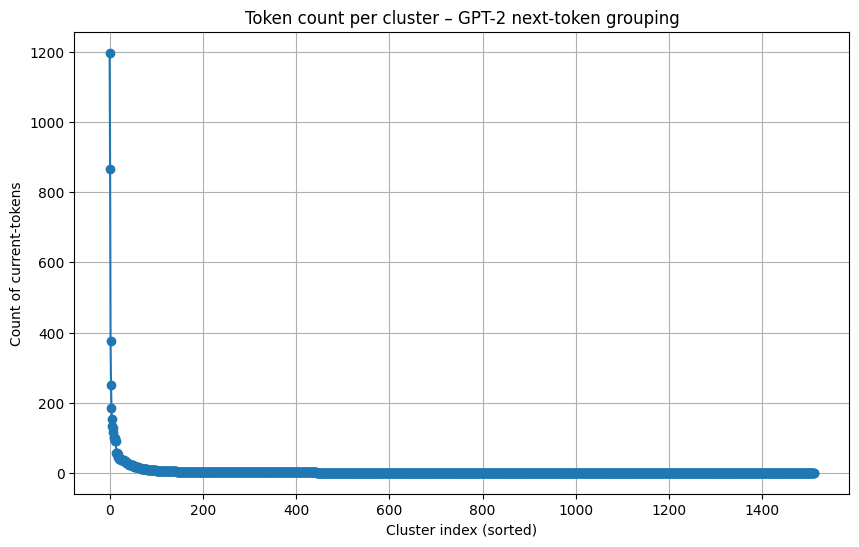

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(10, 6))
plt.plot(range(len(freqs)), freqs, marker='o')
plt.title("Token count per cluster – GPT-2 next-token grouping")
plt.xlabel("Cluster index (sorted)")
plt.ylabel("Count of current-tokens")
plt.grid(True)
plt.show()

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

ranks = np.arange(1, len(freqs)+1)
log_r, log_f = np.log10(ranks), np.log10(freqs)
slope, intercept, r_val, p_val, _ = linregress(log_r, log_f)
y_pred = slope * log_r + intercept

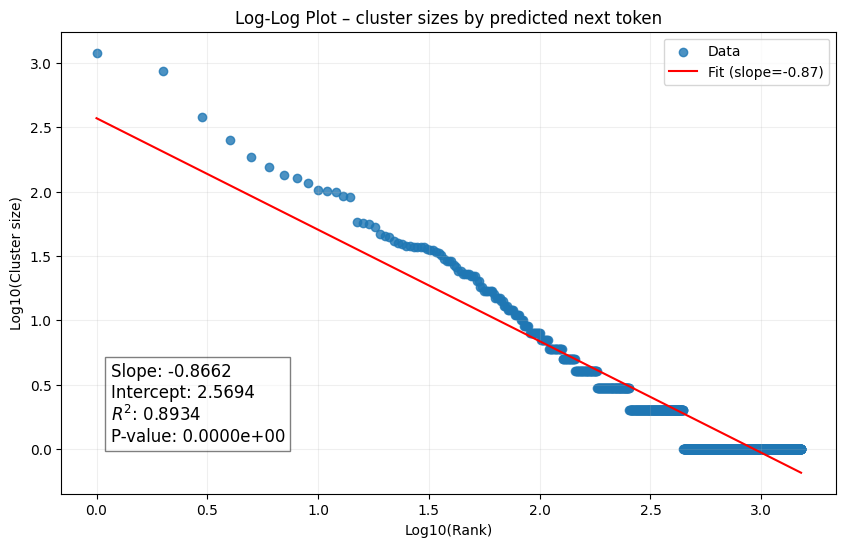


Regression Results:
   - Slope: -0.8662
   - Intercept: 2.5694
   - R-squared: 0.8934
   - P-value: 0.0000e+00


In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(log_r, log_f, alpha=0.8, label="Data")
plt.plot(log_r, y_pred, 'r-', label=f'Fit (slope={slope:.2f})')
plt.title("Log-Log Plot – cluster sizes by predicted next token")
plt.xlabel("Log10(Rank)")
plt.ylabel("Log10(Cluster size)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# annotate regression stats
txt_x = log_r.min() + (log_r.max() - log_r.min())*0.02
txt_y = log_f.min() + (log_f.max() - log_f.min())*0.02
plt.text(txt_x, txt_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n"
         f"$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")
